# Outlier Removal and Analysis
## Author: Nivethan Iyer 1171632


This Notebook is for removing outliers in our dataset and also analysing the effect of removing these outliers. We also analyse the distributions of our outliers to see if it is justified to remove them.

In [14]:
from pyspark.sql import SparkSession, functions as F
import matplotlib.pyplot as plt


spark = SparkSession.builder \
    .appName("green preprocessing") \
    .config("spark.sql.repl.eagerEval.enabled", True) \
    .config("spark.sql.parquet.cacheMetadata", "true") \
    .config("spark.sql.session.timeZone", "Etc/UTC") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

We first load the data and print it out

In [15]:
path1 = "../../../data/insights/joined.parquet"
df = spark.read.parquet(path1)
df.show()
print("length:",df.count())
df_pandas = df.toPandas()



+------------+--------------------+-------------+---------+----------------------------------+--------------------------+----------------------------------+--------------------------+----------------------------------------+----------------+---------------------+--------------------------+------------------------------+-------------------------+------------------------+------------------------+--------------------------+-------------------------+-------------------------+-------------------+--------------------------------+---------------------------+------------------+------------------+--------------------+---------------------------------+--------------------+
|merchant_abn|                name|revenue_level|take_rate|average_merchant_fraud_probability|number_of_unique_consumers|average_consumer_fraud_probability|number_of_repeat_consumers|average_repeat_transactions_per_consumer|number_of_orders|average_cost_of_order|average_spend_per_consumer|average_monthly_diff_consumers|consume

We then Analyse a scatterplot of the consumer fraud probability against each segment before we remove our outliers so we can compare it afterwards to see if there is any significant change.

tech_and_electronics


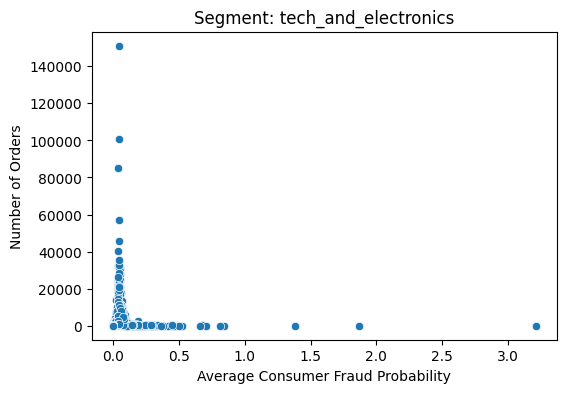

antiques_and_jewellery


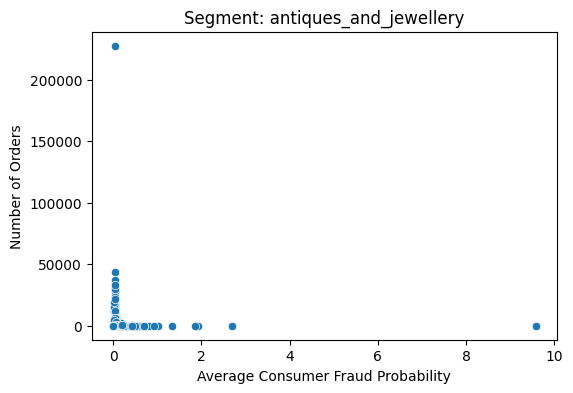

specialized_services


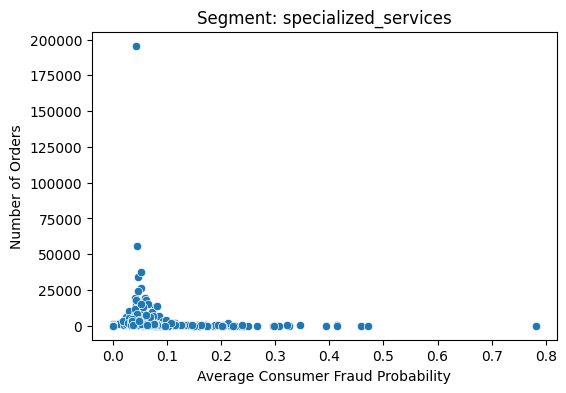

garden_and_furnishings


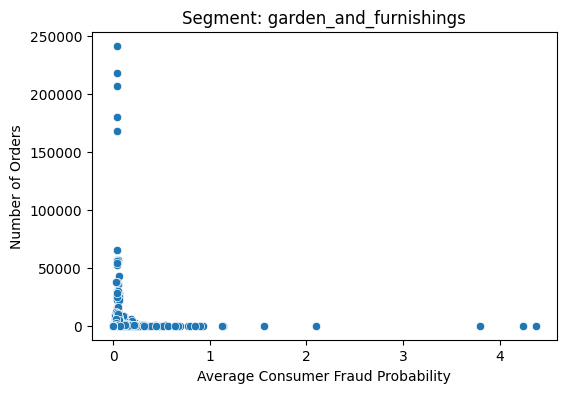

retail_and_novelty


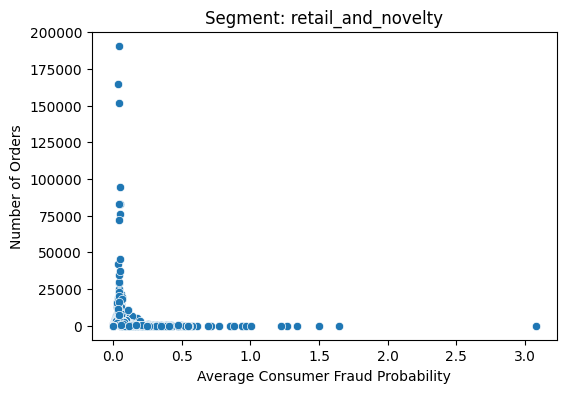

In [3]:
import seaborn as sns

for segment in df_pandas['segment'].unique():
    # Filter the dataframe for each segment
    segment_df = df_pandas[df_pandas['segment'] == segment]
    print(segment)
    plt.figure(figsize=(6,4))
    sns.scatterplot(x='average_consumer_fraud_probability', y='number_of_orders', data=segment_df)
    plt.title(f'Segment: {segment}')
    plt.xlabel('Average Consumer Fraud Probability')
    plt.ylabel('Number of Orders')
    plt.show()


From this scatterplot we can see that some merchants have a consumer fraud probability above 2 while most are below 2

We will now remove the outliers by looking at the number of orders and removing consnumers that are below the 1% quantile in terms of number of unique consumers.

In [18]:
import pandas as pd
import seaborn as sns

# Define a function to calculate upper bound outliers
def get_outliers(df, column_name):
    lower_bound = df[column_name].quantile(0.01)
    print(lower_bound)
    return df[df[column_name] <= lower_bound], lower_bound

outliers_list,lower_bound = get_outliers(df_pandas,'number_of_unique_consumers')
    
# Create a DataFrame from the outliers_list
outliers_df = pd.DataFrame(outliers_list)
display(outliers_df.head())
print("length: ",len(outliers_df))

1.0


,merchant_abn,name,revenue_level,take_rate,average_merchant_fraud_probability,number_of_unique_consumers,average_consumer_fraud_probability,number_of_repeat_consumers,average_repeat_transactions_per_consumer,number_of_orders,...,last_recorded_transaction,transcation_period_months,number_of_postcodes,avg_total_weekly_personal_income,avg_total_weekly_fam_income,avg_median_age,avg_household_size,postcode_reach,avg_num_of_consumers_per_postcode,segment
153,69893361647,Egestas A Dui Corp.,d,0.66,0.0,1,0.0,0,1.0,1,...,2021-10-08,0.0,1,713.0,1745.0,43.0,2.38,0.000379,1.0,antiques_and_jewellery
807,55555661470,Nullam Scelerisque LLC,c,1.83,0.0,1,0.0,0,1.0,1,...,2022-10-15,0.0,1,682.0,1660.0,43.0,2.50,0.000379,1.0,antiques_and_jewellery
1379,24102148742,Amet Metus Aliquam Industries,b,4.24,0.0,1,0.0,0,1.0,1,...,2021-09-03,0.0,1,732.0,1863.0,48.0,2.50,0.000379,1.0,garden_and_furnishings
2474,72300821269,Sem Egestas Blandit Consulting,d,0.95,0.0,1,0.0,0,1.0,1,...,2022-07-14,0.0,1,701.0,1780.0,45.0,2.40,0.000379,1.0,garden_and_furnishings
2973,53829845678,Ac Eleifend Vitae LLP,c,2.79,0.0,1,0.0,0,1.0,1,...,2022-01-15,0.0,1,950.0,2802.0,43.0,3.00,0.000379,1.0,antiques_and_jewellery


length:  45


We will then proceed to analyse the summary statistics of our outliers for certain features to identify any patterns or trends.

In [5]:
grouped_outliers = outliers_df.groupby('segment').size().reset_index(name='count')
display(grouped_outliers)
display("outlier_merchant_fraud",outliers_df.groupby('segment')['average_merchant_fraud_probability'].describe().reset_index())
display("outlier_consumer_fraud",outliers_df.groupby('segment')['average_consumer_fraud_probability'].describe().reset_index())
display("cost of order",outliers_df.groupby('segment')['average_cost_of_order'].describe().reset_index())


,segment,count
0,antiques_and_jewellery,32
1,garden_and_furnishings,6
2,specialized_services,3
3,tech_and_electronics,4


'outlier_merchant_fraud'

,segment,count,mean,std,min,25%,50%,75%,max
0,antiques_and_jewellery,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,garden_and_furnishings,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,specialized_services,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,tech_and_electronics,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


'outlier_consumer_fraud'

,segment,count,mean,std,min,25%,50%,75%,max
0,antiques_and_jewellery,32.0,0.299372,1.693503,0.0,0.0,0.0,0.0,9.5799
1,garden_and_furnishings,6.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0000
2,specialized_services,3.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0000
3,tech_and_electronics,4.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0000


'cost of order'

,segment,count,mean,std,min,25%,50%,75%,max
0,antiques_and_jewellery,32.0,1320.06125,550.185821,140.38,1055.1400,1400.145,1808.3975,1971.66
1,garden_and_furnishings,6.0,1093.68000,376.797311,454.23,963.6925,1162.750,1340.0650,1485.84
2,specialized_services,3.0,1069.24000,442.272486,566.08,905.6100,1245.140,1320.8200,1396.50
3,tech_and_electronics,4.0,977.78750,788.275989,101.42,464.7725,967.430,1480.4450,1874.87


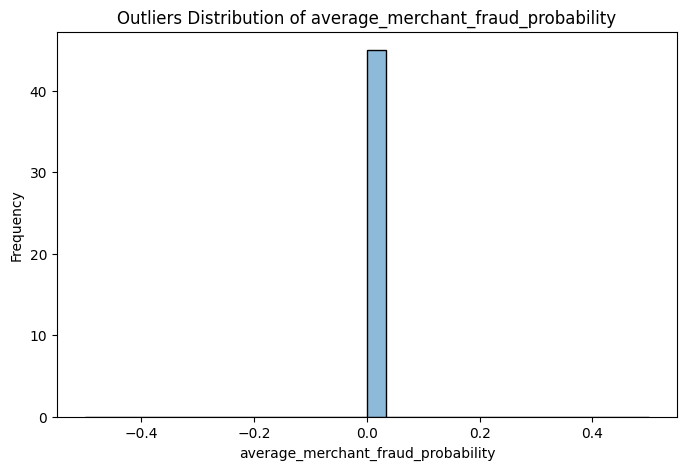

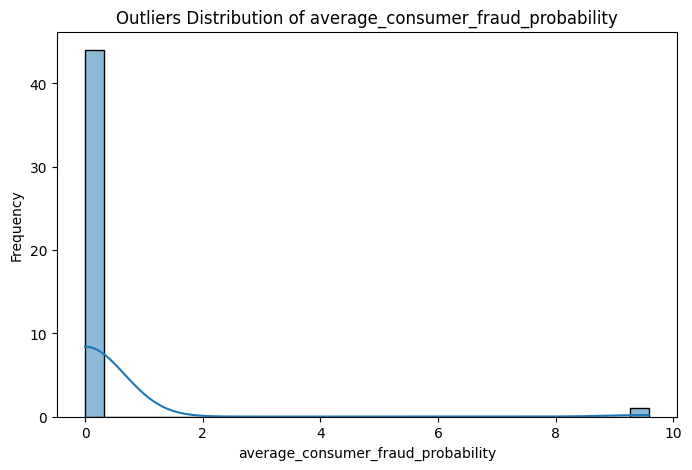

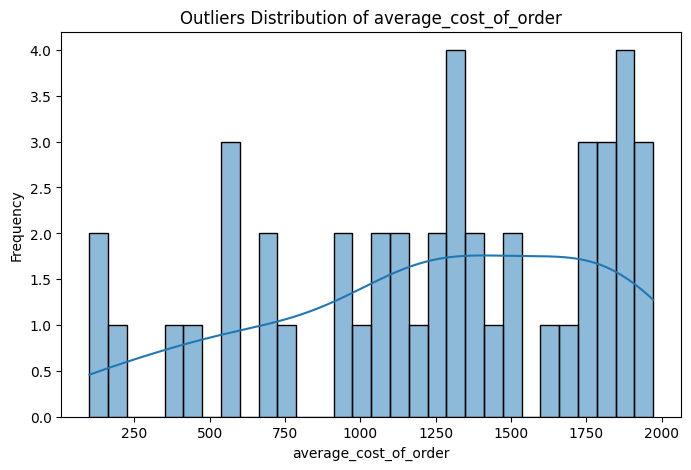

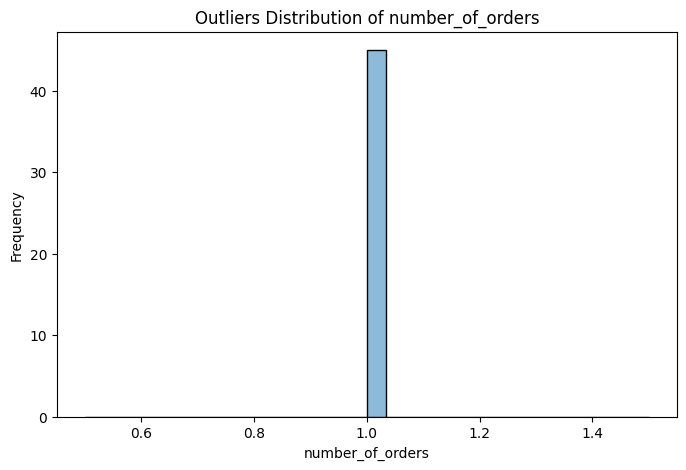

In [6]:
columns_to_plot = ['average_merchant_fraud_probability', 'average_consumer_fraud_probability','average_cost_of_order']

for col in columns_to_plot + ['number_of_orders']:
    plt.figure(figsize=(8,5))
    sns.histplot(outliers_df[col], kde=True, bins=30)  # you can adjust the number of bins as needed
    plt.title(f'Outliers Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

We can see that the average cost of order for these merchants are quite high indicating that a sizeable amount of their transactions would be above 2000 which is our assumed BNPL purchase limit. Hence it makes sense to remove these merchants from our dataset.

In [7]:
df_pandas_cleaned = df_pandas.loc[df_pandas['number_of_orders'] > lower_bound]
print("outliers removed length:", len(df_pandas_cleaned))

outliers removed length: 3864


Now that we have removed the outliers we will conduct our distribution analysis of each segment again to notice any major changes or anomalies. Seeing as a majority of the removed merchants were from the 'antiques and jewllery' segment, we can hypothesise to see some subtantial changes in the pie chart.

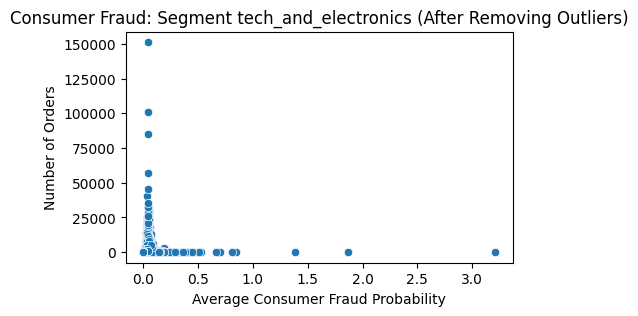

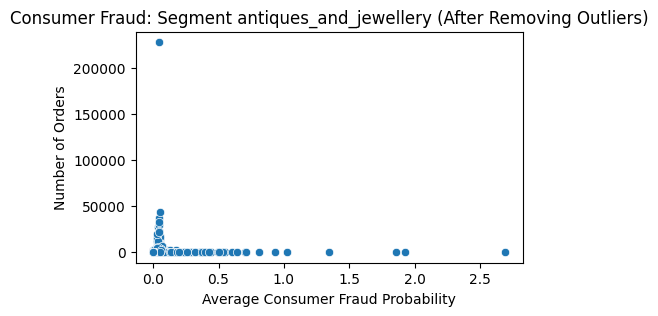

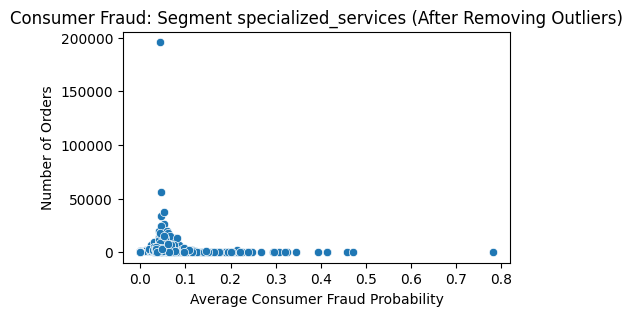

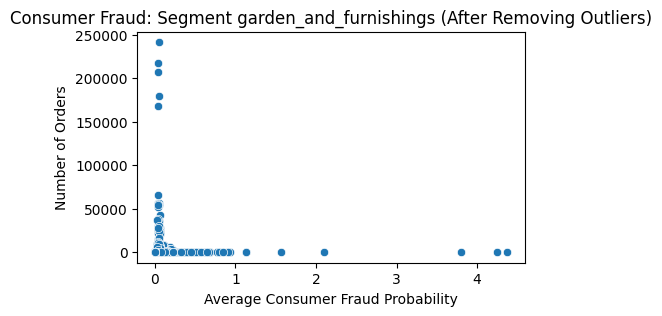

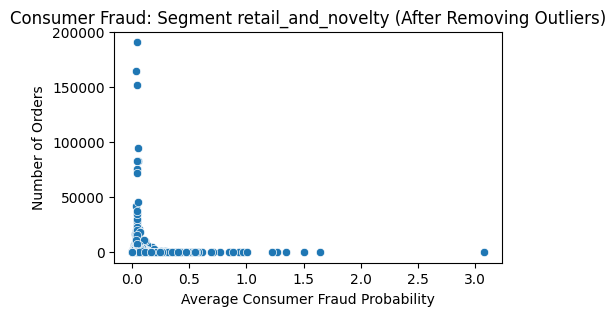

In [8]:
# Loop through each segment and plot
for segment in df_pandas_cleaned['segment'].unique():
    segment_df = df_pandas_cleaned[df_pandas_cleaned['segment'] == segment]

    # Filter the cleaned dataframe for each segment    
    # Plotting the scatter plot for merchant fraud
    plt.figure(figsize=(5,3))
    sns.scatterplot(x='average_consumer_fraud_probability', y='number_of_orders', data=segment_df)
    plt.title(f'Consumer Fraud: Segment {segment} (After Removing Outliers)')
    plt.xlabel('Average Consumer Fraud Probability')
    plt.ylabel('Number of Orders')
    plt.show()


Summary Statistics for average_consumer_fraud_probability:

count    3864.000000
mean        0.081144
std         0.200134
min         0.000000
25%         0.000000
50%         0.042875
75%         0.078367
max         4.373250
Name: average_consumer_fraud_probability, dtype: float64

--------------------------------------------------



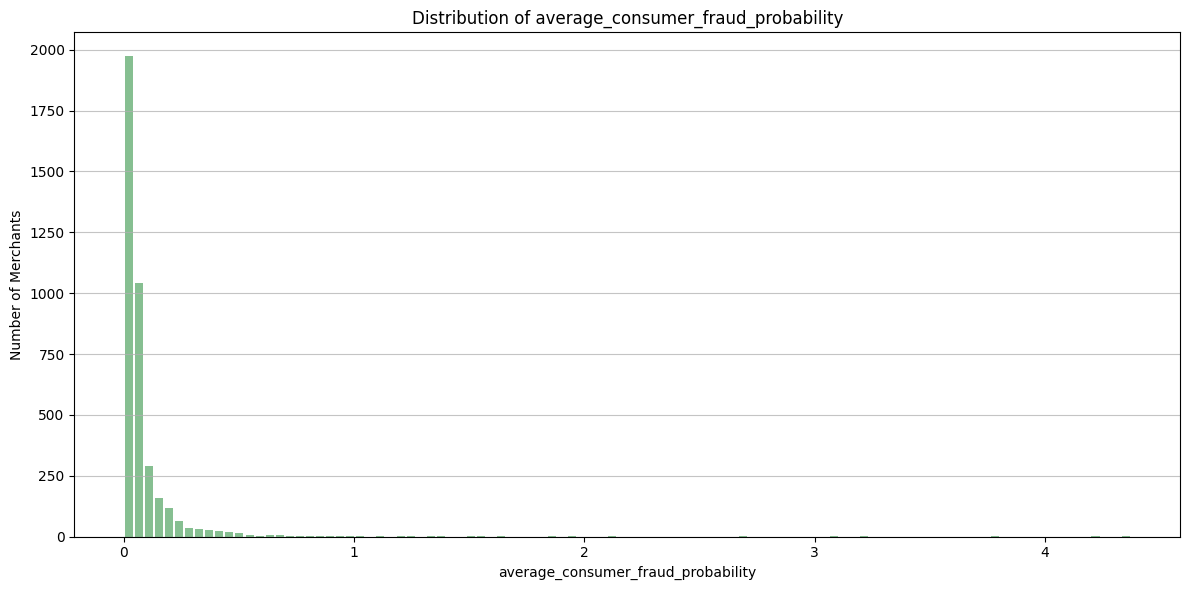

Summary Statistics for avg_median_age:

count    3864.000000
mean       43.126253
std         0.951611
min        34.500000
25%        42.913306
50%        43.106364
75%        43.297048
max        56.000000
Name: avg_median_age, dtype: float64

--------------------------------------------------



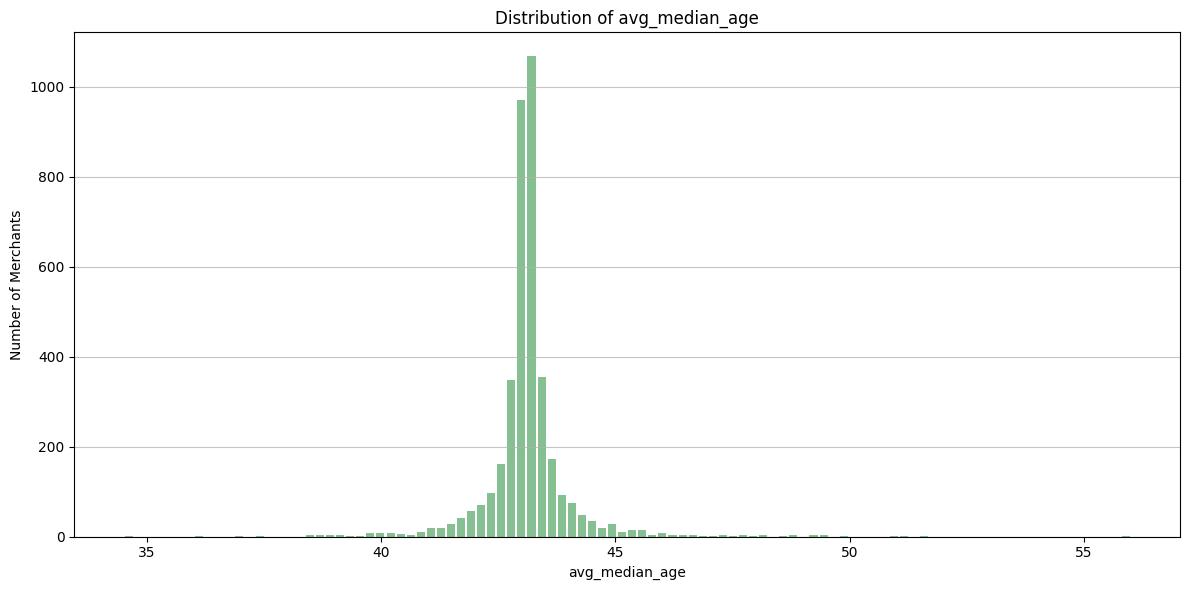

Summary Statistics for avg_total_weekly_personal_income:

count    3864.000000
mean      789.774230
std        32.434129
min       532.750000
25%       783.194220
50%       790.242350
75%       796.677599
max      1249.000000
Name: avg_total_weekly_personal_income, dtype: float64

--------------------------------------------------



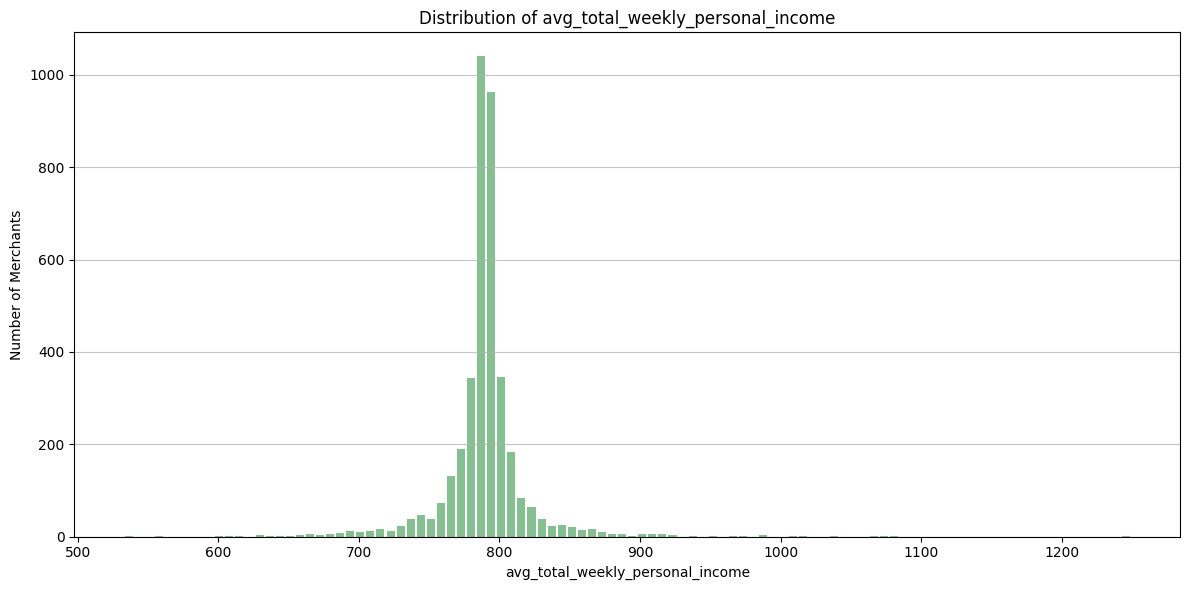

Summary Statistics for take_rate:

count    3864.000000
mean        4.416012
std         1.784146
min         0.100000
25%         2.990000
50%         4.520000
75%         6.040000
max         7.000000
Name: take_rate, dtype: float64

--------------------------------------------------



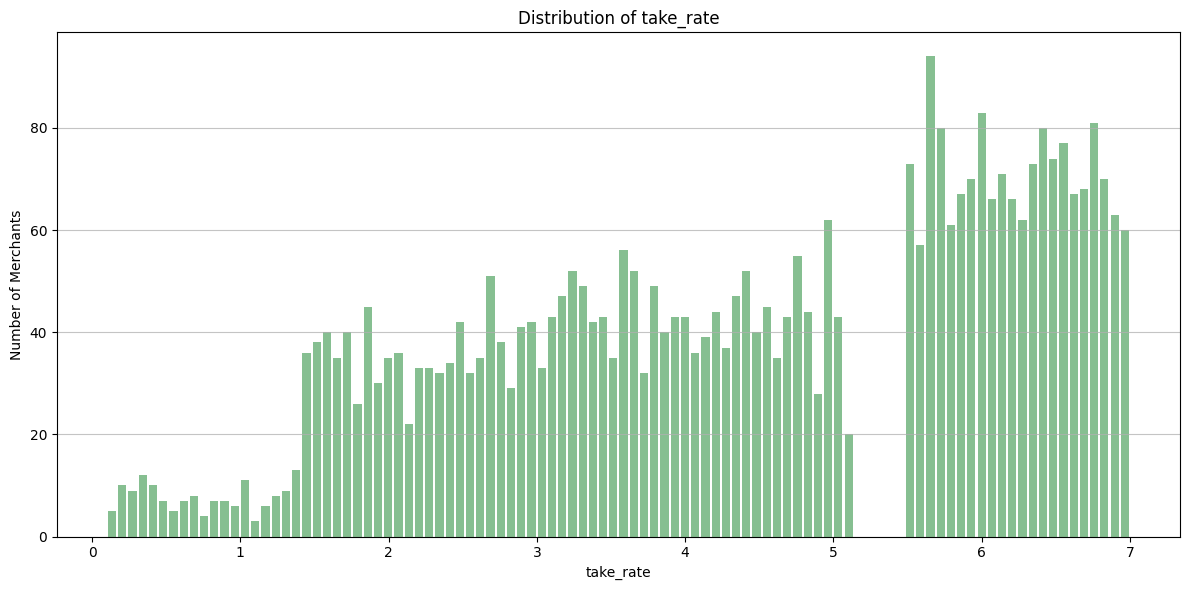

Summary Statistics for average_cost_of_order:

count    3864.000000
mean      427.423923
std       381.761554
min         7.579026
25%       112.837601
50%       299.700546
75%       649.771779
max      1876.796667
Name: average_cost_of_order, dtype: float64

--------------------------------------------------



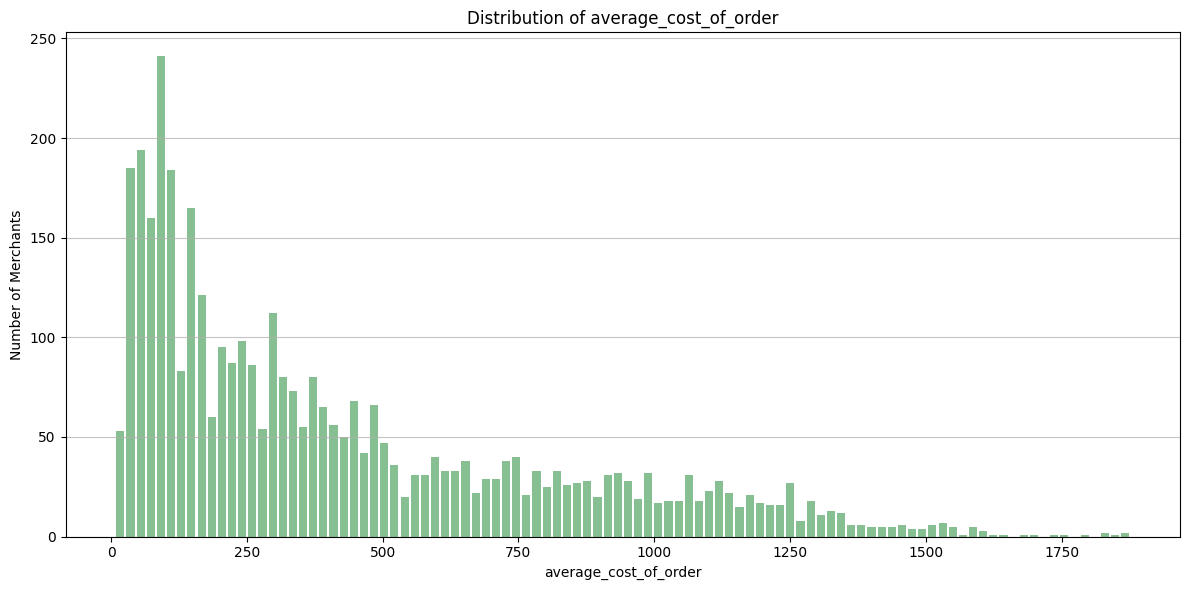

Summary Statistics for number_of_orders:

count      3864.000000
mean       2925.696170
std       12049.572597
min           2.000000
25%          82.750000
50%         364.000000
75%        1807.000000
max      241547.000000
Name: number_of_orders, dtype: float64

--------------------------------------------------



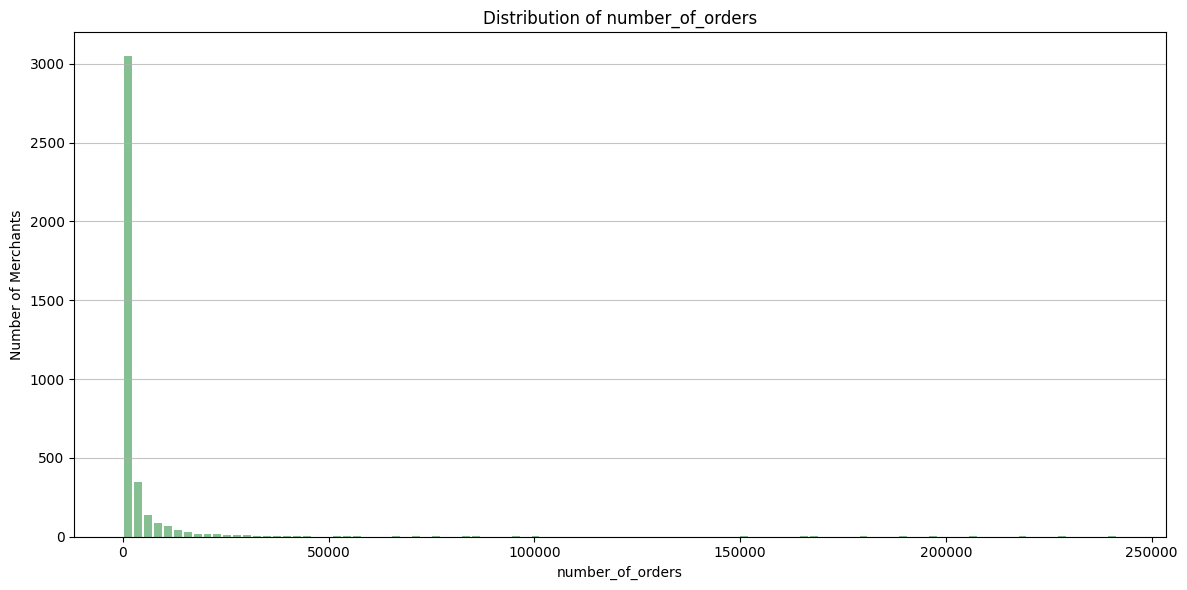

Summary Statistics for number_of_unique_consumers:

count     3864.000000
mean      1746.178054
std       3288.318218
min          2.000000
25%         82.000000
50%        360.000000
75%       1731.250000
max      20115.000000
Name: number_of_unique_consumers, dtype: float64

--------------------------------------------------



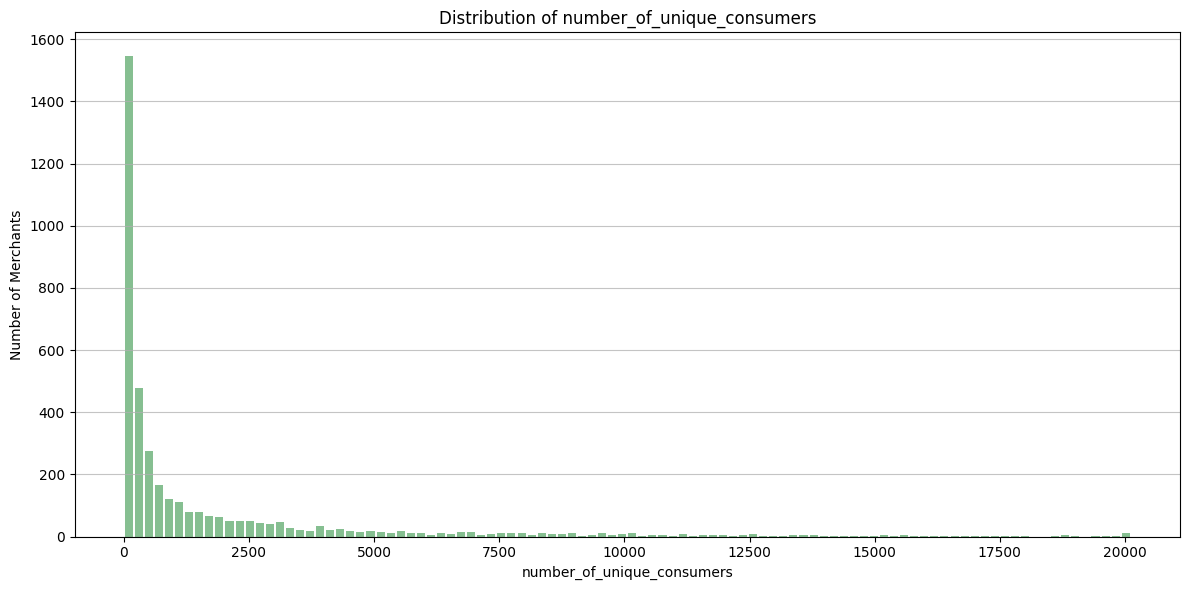

Summary Statistics for average_merchant_fraud_probability:

count    3864.000000
mean        0.003457
std         0.047726
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.168680
Name: average_merchant_fraud_probability, dtype: float64

--------------------------------------------------



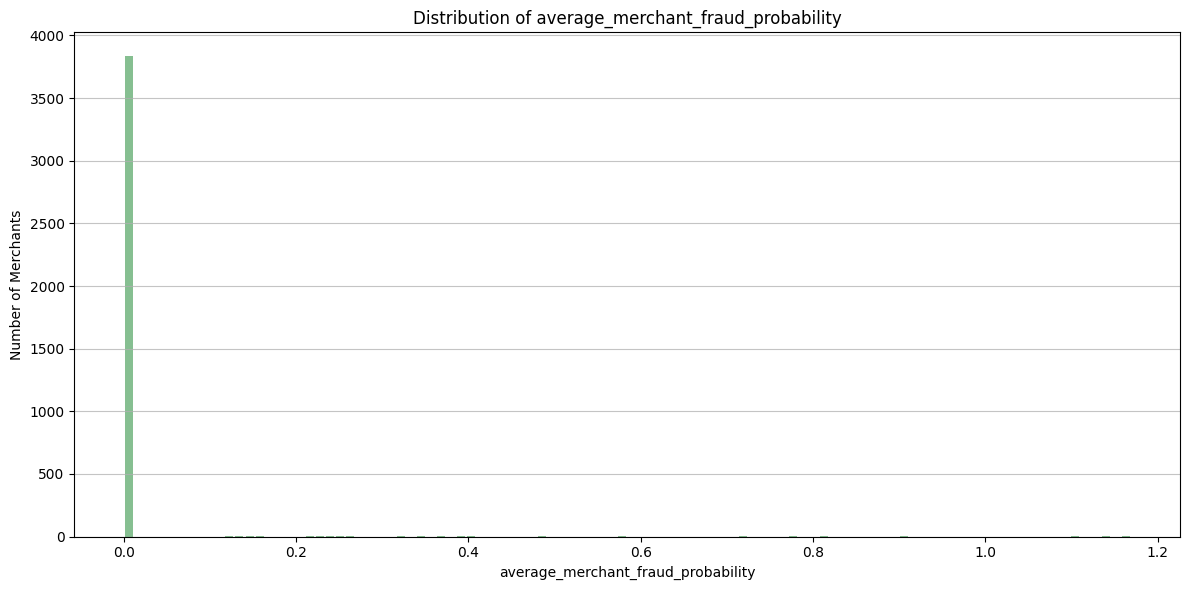

Summary Statistics for average_consumer_fraud_probability:

count    3864.000000
mean        0.081144
std         0.200134
min         0.000000
25%         0.000000
50%         0.042875
75%         0.078367
max         4.373250
Name: average_consumer_fraud_probability, dtype: float64

--------------------------------------------------



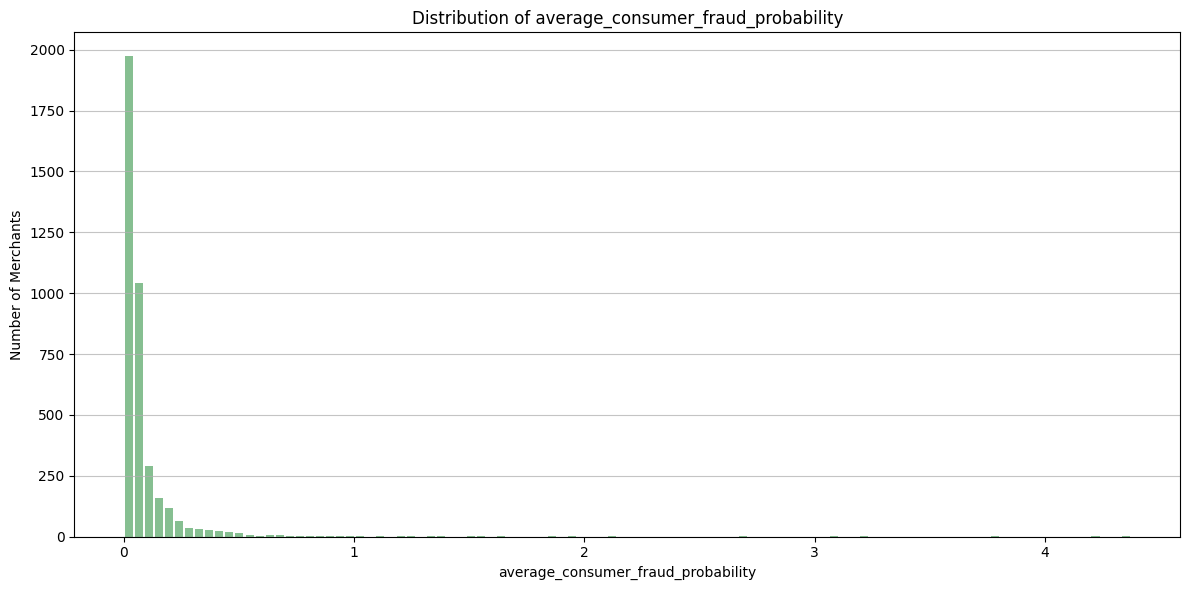

In [9]:
# List of columns to analyze
columns_to_analyze = [
    "average_consumer_fraud_probability", 
    "avg_median_age", 
    "avg_total_weekly_personal_income", 
    "take_rate", 
    "average_cost_of_order", 
    "number_of_orders", 
    "number_of_unique_consumers",
    "average_merchant_fraud_probability",
    "average_consumer_fraud_probability", 
]

df_pandas = df_pandas_cleaned
# For each column, calculate summary statistics and plot the distribution
for column in columns_to_analyze:
    summary_stats = df_pandas[column].describe()
    print(f"Summary Statistics for {column}:\n")
    print(summary_stats)
    print("\n" + "-"*50 + "\n")

    # Plot Distribution
    plt.figure(figsize=(12, 6))
    plt.hist(df_pandas[column], bins=100, color='#86bf91', rwidth=0.8)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Number of Merchants')
    plt.grid(axis='y', alpha=0.75)
    plt.tight_layout()
    plt.show()

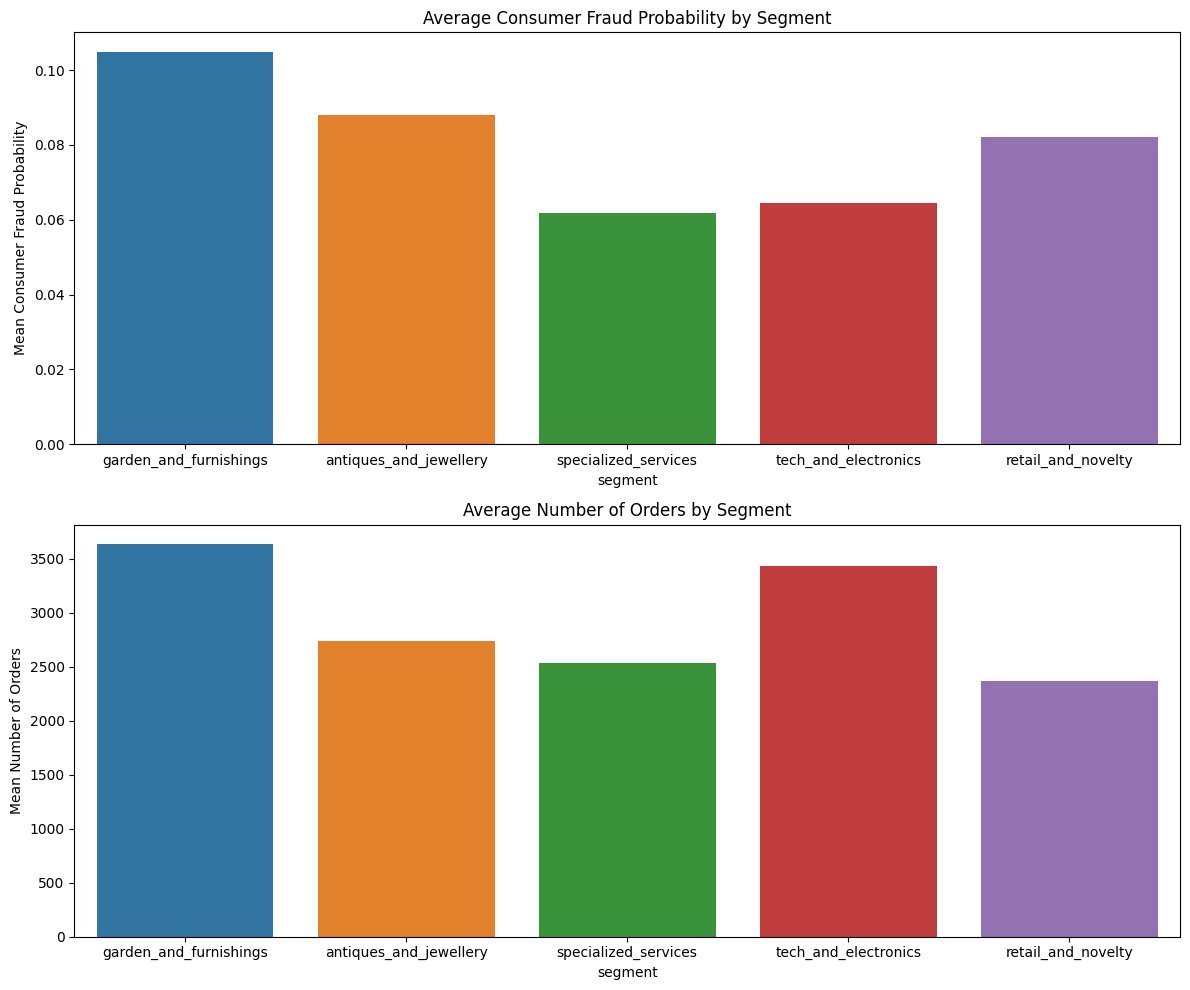

In [10]:
df = spark.createDataFrame(df_pandas_cleaned)
agg_data = df.groupBy("segment").agg(
    F.mean("average_consumer_fraud_probability").alias("mean_consumer_fraud"),
    F.stddev("average_consumer_fraud_probability").alias("stddev_consumer_fraud"),
    F.mean("number_of_orders").alias("mean_orders"),
    F.stddev("number_of_orders").alias("stddev_orders")
)

# Convert the aggregated data to Pandas DataFrame for visualization
agg_data_pandas = agg_data.toPandas()

# Plotting
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Average consumer fraud probability by segment
sns.barplot(x="segment", y="mean_consumer_fraud", data=agg_data_pandas, ax=axes[0])
axes[0].set_title('Average Consumer Fraud Probability by Segment')
axes[0].set_ylabel('Mean Consumer Fraud Probability')

# Number of orders by segment
sns.barplot(x="segment", y="mean_orders", data=agg_data_pandas, ax=axes[1])
axes[1].set_title('Average Number of Orders by Segment')
axes[1].set_ylabel('Mean Number of Orders')

plt.tight_layout()
plt.show()

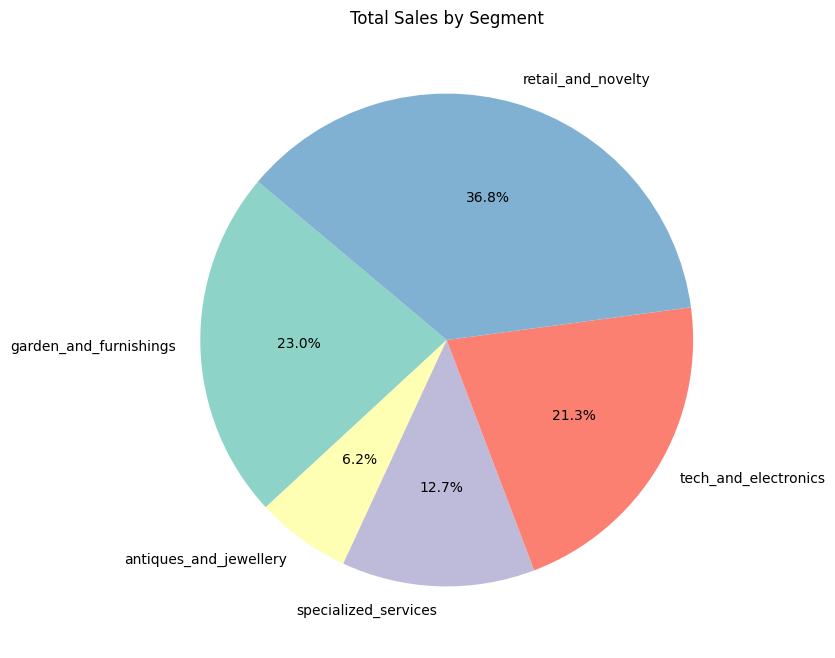

In [11]:
# Group by segment and aggregate total sales for each segment
agg_sales = df.groupBy("segment").agg(
    F.sum(df.number_of_orders * df.average_cost_of_order).alias("total_sales")
)

# Convert the aggregated data to a Pandas DataFrame for visualization
sales_pandas = agg_sales.toPandas()

# Plotting
plt.figure(figsize=(12, 8))
plt.pie(sales_pandas["total_sales"], labels=sales_pandas["segment"], autopct='%1.1f%%', startangle=140, colors=sns.color_palette("Set3", len(sales_pandas)))
plt.title('Total Sales by Segment')
plt.show()

As hypothesised we can see a change in the pie chart sizes from our original pre-outlier removed data.

In [12]:
df.write.mode('overwrite').parquet("../../../data/curated/removed_outliers.parquet")


In [13]:
spark.stop()